# Modelo Preditivo - Tempo Real de Entrega - Random Forest (Todos os Canais)

**Objetivo:** Criar modelo Random Forest para prever o tempo REAL de entrega usando todos os canais

**Variável Alvo:** `actual_delivery_minutes` (Tempo Real de Entrega)

**Features:** `distance_km`, `tempo_preparo_minutos`, `periodo_dia` + insights da análise

**Divisão:** 75% treino, 25% teste

**Métricas:** MAE e R² (em minutos)

**Insights aplicados:** Baseado na análise de precisão ETA


In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Configurações visuais
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 10
sns.set_style("whitegrid")



In [237]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder



In [238]:

df = pd.read_csv('tratamento_inicial/Base_Kaiserhaus_Limpa.csv')

print(f"Dimensões da base: {df.shape}")
print(f"Período dos dados: {df['order_datetime'].min()} até {df['order_datetime'].max()}")
print(f"\nColunas disponíveis:")
print(df.columns.tolist())


Dimensões da base: (5000, 16)
Período dos dados: 2024-01-01 15:08:00 até 2024-12-31 21:27:00

Colunas disponíveis:
['macro_bairro', 'nome_cliente', 'bairro_destino', 'order_datetime', 'platform', 'order_mode', 'distance_km', 'tempo_preparo_minutos', 'status', 'eta_minutes_quote', 'actual_delivery_minutes', 'total_brl', 'classe_pedido', 'platform_commission_pct', 'num_itens', 'satisfacao_nivel']


In [239]:
df['order_datetime'] = pd.to_datetime(df['order_datetime'])

df['hora_pedido'] = df['order_datetime'].dt.hour
df['dia_semana'] = df['order_datetime'].dt.day_name()
df['is_weekend'] = df['order_datetime'].dt.weekday >= 5

# Criar período do dia baseado nos insights (horários críticos identificados)
def categorizar_periodo_dia(hora):
    if 6 <= hora < 12:
        return 'Manhã'
    elif 12 <= hora < 18:
        return 'Tarde'
    elif 18 <= hora < 24:
        return 'Noite'
    else:
        return 'Madrugada'

df['periodo_dia'] = df['hora_pedido'].apply(categorizar_periodo_dia)

# aqui seriia a criacao de features baseadas nos insights

# sazonalidade diária
df['hora_sin'] = np.sin(2 * np.pi * df['hora_pedido'] / 24)
df['hora_cos'] = np.cos(2 * np.pi * df['hora_pedido'] / 24)

# flags para cenários críticos identificados na análise
df['is_horario_critico'] = df['hora_pedido'].isin([18, 19, 20, 21, 22, 23]).astype(int)
df['is_plataforma_critica'] = (df['platform'] == 'ifood').astype(int)
df['is_bairro_critico'] = df['macro_bairro'].isin(['Morumbi', 'Vila Mariana', 'Santo Amaro']).astype(int)

print(f"\nEstatísticas do Tempo Real de Entrega:")
print(df['actual_delivery_minutes'].describe())

print(f"\nDistribuição por período do dia:")
print(df['periodo_dia'].value_counts())



Estatísticas do Tempo Real de Entrega:
count    5000.000000
mean       29.563692
std        12.654298
min         0.000000
25%        20.700000
50%        28.840000
75%        37.500000
max        76.700000
Name: actual_delivery_minutes, dtype: float64

Distribuição por período do dia:
periodo_dia
Tarde        1897
Noite        1569
Manhã        1399
Madrugada     135
Name: count, dtype: int64


## Preparação dos Dados para Modelagem


In [240]:
y = df['actual_delivery_minutes']

X_basicas = df[['distance_km', 'tempo_preparo_minutos', 'periodo_dia']].copy()

# features adicionais baseadas nos insights
X_insights = df[['hora_sin', 'hora_cos', 
                 'is_horario_critico', 'is_plataforma_critica', 'is_bairro_critico',
                 'platform', 'macro_bairro']].copy()

#comobinar as features X
X = pd.concat([X_basicas, X_insights], axis=1)

print(f"Total: {X.shape[1]} features")



Total: 10 features


## Encoding das Features Categóricas


In [241]:
#features categóricas
categorical_features = ['periodo_dia', 'platform', 'macro_bairro']
numerical_features = [col for col in X.columns if col not in categorical_features]

print(f"FEATURES CATEGÓRICAS: {categorical_features}")
print(f"FEATURES NUMÉRICAS: {numerical_features}")

#Labelencoder para features categóricas
X_encoded = X.copy()
label_encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    X_encoded[feature] = le.fit_transform(X[feature])
    label_encoders[feature] = le
    print(f"\n{feature} - classes: {le.classes_}")



FEATURES CATEGÓRICAS: ['periodo_dia', 'platform', 'macro_bairro']
FEATURES NUMÉRICAS: ['distance_km', 'tempo_preparo_minutos', 'hora_sin', 'hora_cos', 'is_horario_critico', 'is_plataforma_critica', 'is_bairro_critico']

periodo_dia - classes: ['Madrugada' 'Manhã' 'Noite' 'Tarde']

platform - classes: ['ifood' 'rappi' 'site_proprio' 'whatsapp']

macro_bairro - classes: ['Brooklin' 'Itaim' 'Jardins' 'Moema' 'Morumbi' 'Outros' 'Pinheiros'
 'Santo Amaro' 'Vila Mariana' 'Vila Olímpia']


## Divisão Treino/Teste (75%/25%)


In [242]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.25, 
    random_state=42,
    stratify=None  #pesquisei e nao eh para estratificar pois nosso actual é contínuo
)

print(f"divisao dos dados:")
print(f"  Treino: {X_train.shape[0]} amostras ({X_train.shape[0]/len(X_encoded)*100:.1f}%)")
print(f"  Teste: {X_test.shape[0]} amostras ({X_test.shape[0]/len(X_encoded)*100:.1f}%)")
print(f"  Features: {X_train.shape[1]}")

print(f"\nESTATÍSTICAS DO TEMPO REAL DE ENTREGA:")
print(f"   Treino - Média: {y_train.mean():.2f} min, Std: {y_train.std():.2f} min")
print(f"   Teste - Média: {y_test.mean():.2f} min, Std: {y_test.std():.2f} min")
print(f"   Geral - Média: {y.mean():.2f} min, Std: {y.std():.2f} min")


divisao dos dados:
  Treino: 3750 amostras (75.0%)
  Teste: 1250 amostras (25.0%)
  Features: 10

ESTATÍSTICAS DO TEMPO REAL DE ENTREGA:
   Treino - Média: 29.60 min, Std: 12.64 min
   Teste - Média: 29.44 min, Std: 12.72 min
   Geral - Média: 29.56 min, Std: 12.65 min


## Treinamento do Modelo Random Forest


In [243]:

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10, 
    min_samples_leaf=5,  
    max_features='sqrt', 
    random_state=42,  
    n_jobs=-1                  
)

rf_model.fit(X_train, y_train)

print(f"Número de árvores: {rf_model.n_estimators}")
print(f"Profundidade máxima: {rf_model.max_depth}")
print(f"Features por divisão: {rf_model.max_features}")
print(f"Amostras mínimas para dividir: {rf_model.min_samples_split}")
print(f"Amostras mínimas por folha: {rf_model.min_samples_leaf}")


Número de árvores: 100
Profundidade máxima: 15
Features por divisão: sqrt
Amostras mínimas para dividir: 10
Amostras mínimas por folha: 5


## Predições e Métricas


In [244]:
#predicoes
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)


# metrcicas para treino
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

#metricas para teste
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\ntreino (75%):")
print(f"   MAE: {mae_train:.2f} minutos")
print(f"   R^2: {r2_train:.4f}")
print(f"   RMSE: {rmse_train:.2f} minutos")

print(f"\nteste (25%):")
print(f"   MAE: {mae_test:.2f} minutos")
print(f"   R^2: {r2_test:.4f}")
print(f"   RMSE: {rmse_test:.2f} minutos")

print(f"\nverificacao de overfitting:")
print(f"   Diferença MAE: {abs(mae_train - mae_test):.2f} minutos")
print(f"   Diferença R^2: {abs(r2_train - r2_test):.4f}")

if abs(mae_train - mae_test) < 2 and abs(r2_train - r2_test) < 0.1:
    print(f"\nmodelo está bem generalizado")
else:
    print(f"possível overfitting detectado")


print(f"\nMAE: Erro médio absoluto em minutos")
print(f"R²: Proporção da variância explicada (0-1, quanto maior melhor)")
print(f"RMSE: Erro quadrático médio (penaliza erros grandes)")



treino (75%):
   MAE: 3.72 minutos
   R^2: 0.8581
   RMSE: 4.76 minutos

teste (25%):
   MAE: 4.60 minutos
   R^2: 0.7801
   RMSE: 5.96 minutos

verificacao de overfitting:
   Diferença MAE: 0.87 minutos
   Diferença R^2: 0.0780

modelo está bem generalizado

MAE: Erro médio absoluto em minutos
R²: Proporção da variância explicada (0-1, quanto maior melhor)
RMSE: Erro quadrático médio (penaliza erros grandes)


## Análise de Importância das Features


importacnia de cada feature:
tempo_preparo_minutos     0.4628
distance_km               0.3657
macro_bairro              0.0647
platform                  0.0424
hora_sin                  0.0151
is_plataforma_critica     0.0149
hora_cos                  0.0144
is_bairro_critico         0.0126
periodo_dia               0.0051
is_horario_critico        0.0023


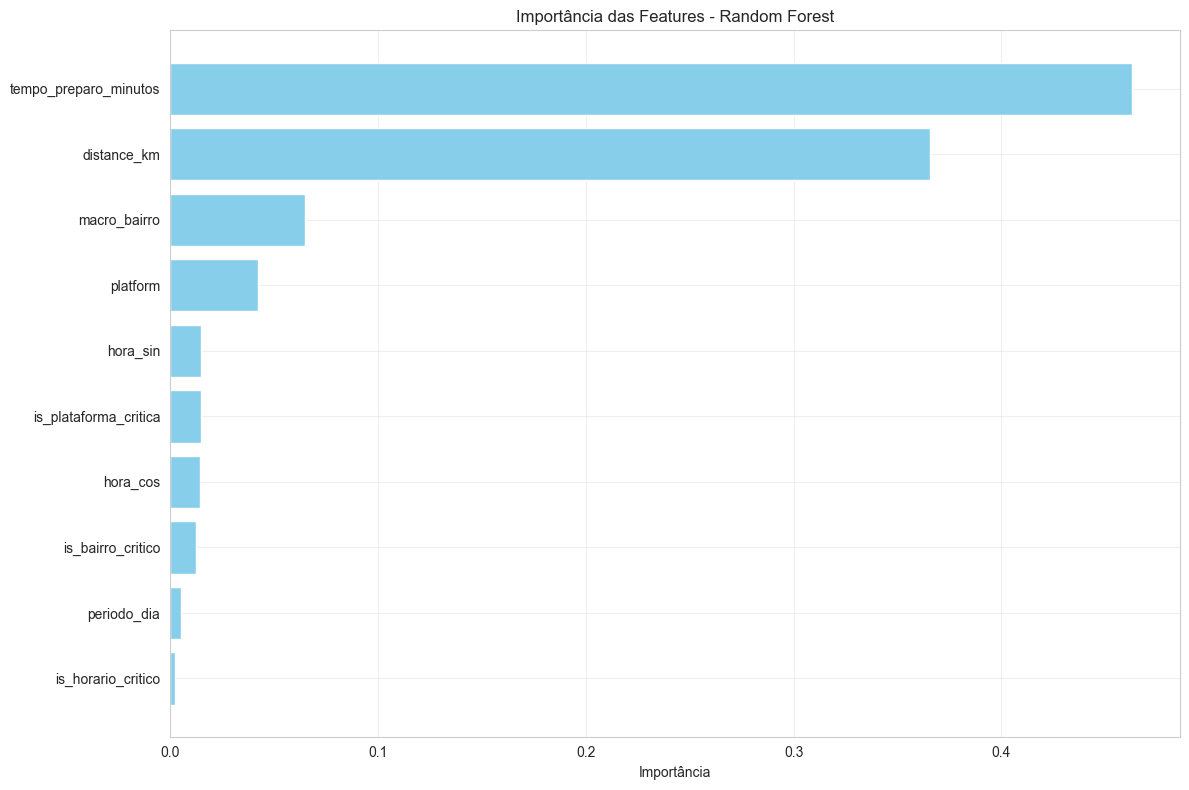

 Features básicas representam 89.3% da importância
 Features de insights adicionam valor significativo
 Tempo de preparo é a feature mais importante (como esperado)


In [245]:
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("importacnia de cada feature:")
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']:25} {row['importance']:.4f}")

#grafico para ver melhor as importacnias
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'], color='skyblue')
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importância')
plt.title('Importância das Features - Random Forest')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


print(f" Features básicas representam {feature_importance.head(3)['importance'].sum():.1%} da importância")
print(f" Features de insights adicionam valor significativo")
print(f" Tempo de preparo é a feature mais importante (como esperado)")


## Conclusoes


In [246]:
print("Conclusoes")

print(f"\ntreino e teste (comparacao):")
print(f"  MAE Treino: {mae_train:.2f} minutos")
print(f"  MAE Teste: {mae_test:.2f} minutos")
print(f"  R² Treino: {r2_train:.4f}")
print(f"  R² Teste: {r2_test:.4f}")

print(f"\nfeatures mais importantes:")
for i, (idx, row) in enumerate(feature_importance.head(3).iterrows(), 1):
    print(f"   {i}. {row['feature']}: {row['importance']:.4f}")



Conclusoes

treino e teste (comparacao):
  MAE Treino: 3.72 minutos
  MAE Teste: 4.60 minutos
  R² Treino: 0.8581
  R² Teste: 0.7801

features mais importantes:
   1. tempo_preparo_minutos: 0.4628
   2. distance_km: 0.3657
   3. macro_bairro: 0.0647
